# Train Labal Classifiers

We try:
1. Naive Bayes
2. MLP
  a. Grid search CV
  b. PCA - MLP
  c. MLP trained until perfect

All models take (n.obs, n.features) array as input.
where features are flattened gray scale image matrix

In [47]:
import os
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.externals import joblib
from matplotlib import pyplot as plt
import seaborn as sns

np.random.seed(123)

In [48]:
# we don't use keras for modelling. just for image augmentation
from keras.preprocessing.image import ImageDataGenerator

In [49]:
proj_root = os.path.abspath(os.path.join('../')) 
datadir = os.path.join(proj_root, 'data/labels/')
modeldir = os.path.join(proj_root, 'models/')
arcdir = os.path.join(proj_root, 'models/archive')

if not os.path.isdir(modeldir): os.path.makedirs(modeldir)
if not os.path.isdir(modeldir): os.path.makedirs(arcdir)

# Load Data

In [50]:
X1 = np.load(os.path.join(datadir, 'X-1.npy'))
Y1 = np.load(os.path.join(datadir, 'Y-1.npy'))

X2 = np.load(os.path.join(datadir, 'X-2.npy'))
Y2 = np.load(os.path.join(datadir, 'Y-2.npy'))


X = np.vstack((X1, X2))
Y = np.concatenate((Y1, Y2))

X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.5, stratify=Y, random_state=87)

pd.concat([pd.Series(Y_train).value_counts(),
           pd.Series(Y_test).value_counts()], axis=1)

,0,1
0,8,8
1,51,50
2,16,15
3,11,10
4,10,10
5,10,11
6,11,10
7,10,10
8,11,11
9,11,12


In [51]:
# Define preprocessor class for pipelining
class MyTrans:
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X.reshape(X.shape[0], -1)
    def get_params(self, deep=True):
        return {}

# quick test
a = X[0].flatten()
trans = MyTrans()
trans.fit(X)
b = trans.transform(X)[0]
np.all(a==b)

True

# Fit Gaussian Naive Bayes

In [52]:
# Fit Gaussian Naive Bayes
pipe = Pipeline([
    ('flatten data to "obs*feature" shape', MyTrans()), 
    ('NB', GaussianNB())
])
fit = pipe.fit(X_train, Y_train)

print('train performance', fit.score(X_train, Y_train))
print('test performance', fit.score(X_test, Y_test))

train performance 1.0
test performance 1.0


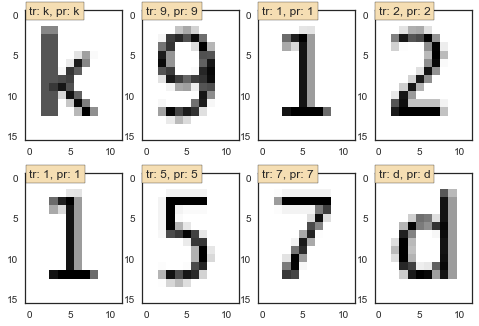

In [53]:
# observe prediction or random cases
def random_plot(X, y, predicted):
    sns.set_style('white')
    indices = np.random.choice(len(y), min(8, len(y)))
    count = 0
    for i in indices:
        count += 1
        ax = plt.subplot(2, 4, count)
        ax.imshow(X[i], cmap='gray')
        ax.text(0, 0, 
                'tr: %s, pr: %s' % (y[i], predicted[i]), \
                bbox={'facecolor':"wheat"})
    plt.show(block=False)

pred = fit.predict(X_test)
random_plot(X_test, Y_test, pred)


In [54]:
# Check the robustness to small variation
def generate_augmented_data(X, Y, target_size, seed=87):
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, 
                                 data_format='channels_last', channel_shift_range=0.5)
    out_X = None
    out_Y = None
    for x,y in datagen.flow(np.expand_dims(X, axis=4), Y, seed=seed):
        if out_X is None:
            out_X = x
            out_Y = y
        else:
            out_X = np.vstack([out_X, x])
            out_Y = np.concatenate([out_Y, y])
        if len(out_Y) >= target_size: 
            break
    out_X = out_X.squeeze()
    return out_X, out_Y

X_generated, Y_generated = generate_augmented_data(X_test, Y_test, 500)

             precision    recall  f1-score   support

          0       0.67      0.50      0.57        16
          1       0.87      0.59      0.70       100
          2       0.79      0.37      0.50        30
          3       0.11      0.25      0.16        20
          4       0.38      0.50      0.43        20
          5       0.91      0.45      0.61        22
          6       0.38      0.25      0.30        20
          7       0.34      0.75      0.47        20
          8       0.17      0.27      0.21        22
          9       0.56      0.38      0.45        24
          d       0.36      0.50      0.42        26
          k       0.86      0.87      0.87       182

avg / total       0.70      0.62      0.64       502



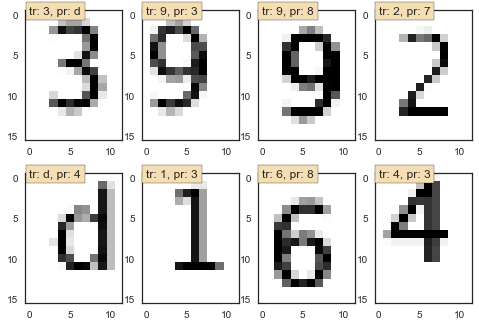

In [55]:
predicted = fit.predict(X_generated) 
print(classification_report(Y_generated, predicted))
#print(confusion_matrix(Y_generated, prdicted))
wrong = (Y_generated != predicted)
random_plot(X_generated[wrong], Y_generated[wrong], predicted[wrong])

In [56]:
# train the model with augmented data set
X_train_gen, Y_train_gen = generate_augmented_data(X_train, Y_train, 10000)
fit_nb = pipe.fit(X_train_gen, Y_train_gen)

X_test_gen, Y_test_gen = generate_augmented_data(X_test, Y_test, 10000)

pred = fit_nb.predict(X_test_gen)

In [57]:
# performance on the original test data
fit_nb.score(X_test, Y_test)

1.0

In [58]:
pd.crosstab(pd.Series(Y_test_gen), pd.Series(pred), margins=True)

col_0,0,1,2,3,4,5,6,7,8,9,d,k,All
row_0,,,,,,,,,,,,,
0,156,0,0,0,2,1,109,0,3,16,32,0,319
1,0,1687,11,63,0,9,0,9,201,1,0,13,1994
2,0,37,494,0,6,0,2,24,34,0,2,0,599
3,2,48,20,188,3,69,0,12,56,0,0,0,398
4,0,2,3,0,333,2,0,0,24,3,33,0,400
5,0,1,0,0,0,350,0,4,66,17,0,2,440
6,6,0,0,0,0,2,287,0,83,5,16,1,400
7,8,0,55,0,0,0,0,305,25,3,2,2,400
8,3,2,0,0,14,45,91,0,265,3,2,14,439


In [59]:
print(classification_report(Y_test_gen, pred))

             precision    recall  f1-score   support

          0       0.77      0.49      0.60       319
          1       0.89      0.85      0.87      1994
          2       0.84      0.82      0.83       599
          3       0.75      0.47      0.58       398
          4       0.84      0.83      0.84       400
          5       0.64      0.80      0.71       440
          6       0.52      0.72      0.60       400
          7       0.84      0.76      0.80       400
          8       0.24      0.60      0.35       439
          9       0.89      0.84      0.87       479
          d       0.80      0.72      0.76       519
          k       0.99      0.88      0.93      3626

avg / total       0.85      0.80      0.82     10013



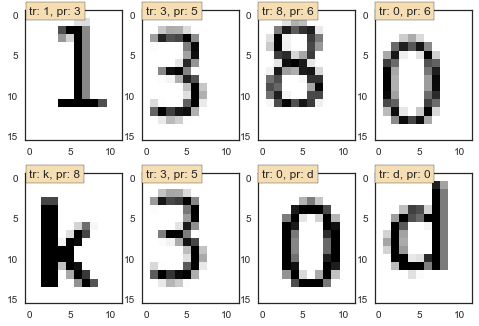

In [60]:
wrong = (Y_test_gen != pred)
random_plot(X_test_gen[wrong], Y_test_gen[wrong], pred[wrong])

In [61]:
savename = os.path.join(modeldir, 'label_nb.pkl')
joblib.dump(fit_nb.named_steps['NB'], savename)

['/home/kota/Documents/kgschart/models/label_nb.pkl']

In [62]:
#pred = fit_nb2.predict(X_test_gen)

In [63]:
#pd.crosstab(pd.Series(Y_test_gen), pd.Series(pred), margins=True)

In [64]:
#print(classification_report(Y_test_gen, pred))

In [65]:
#wrong = (Y_test_gen != pred)
#random_plot(X_test_gen[wrong], Y_test_gen[wrong], pred[wrong])

In [66]:
# performance on the original test data
#fit_nb2.score(X_test, Y_test)

**Summary of Naive Bayes**

- 100% accuracy on original data
- Not robust to image augmentation. Accuracy becomes 70%
- Trained on augmented data, accuracy reaches 85% (still 100% accurate for original data)
- Polynomial features does not seem to help (reduces to 83%)

# Fit Multilayer Perceptron

In [67]:
pipe = Pipeline([
    ('flatten data to "obs*feature" shape', MyTrans()), 
    ('fit to multilayer perceptron', \
     MLPClassifier((100,), alpha=1, max_iter=1000))
])
fit = pipe.fit(X_train, Y_train)
print(fit.score(X_train, Y_train))
print(fit.score(X_test, Y_test))
print(fit.score(X_test_gen, Y_test_gen))

1.0
1.0
0.660341555977


In [68]:
fit_mlp = pipe.fit(X_train_gen, Y_train_gen)

In [69]:
print(fit_mlp.score(X_test, Y_test))
print(fit_mlp.score(X_train_gen, Y_train_gen))
print(fit_mlp.score(X_test_gen, Y_test_gen))
pred = fit_mlp.predict(X_test_gen)

1.0
0.991511035654
0.987815839409


In [70]:
print(classification_report(Y_test_gen, pred))
pd.crosstab(pd.Series(Y_test_gen), pd.Series(pred), margins=True)

             precision    recall  f1-score   support

          0       0.98      0.97      0.98       319
          1       1.00      1.00      1.00      1994
          2       0.99      0.97      0.98       599
          3       0.99      0.97      0.98       398
          4       0.98      0.96      0.97       400
          5       1.00      0.99      1.00       440
          6       0.96      0.94      0.95       400
          7       0.93      0.98      0.96       400
          8       0.98      0.96      0.97       439
          9       0.98      0.97      0.98       479
          d       0.97      0.99      0.98       519
          k       1.00      1.00      1.00      3626

avg / total       0.99      0.99      0.99     10013



col_0,0,1,2,3,4,5,6,7,8,9,d,k,All
row_0,,,,,,,,,,,,,
0,311,0,0,0,0,0,3,1,0,0,4,0,319
1,0,1994,0,0,0,0,0,0,0,0,0,0,1994
2,0,0,581,0,0,0,0,18,0,0,0,0,599
3,0,6,0,385,3,0,0,4,0,0,0,0,398
4,0,0,2,0,385,0,0,0,0,2,11,0,400
5,0,0,0,0,0,436,0,0,0,0,0,4,440
6,4,0,0,0,0,0,378,0,9,7,0,2,400
7,0,0,2,2,0,0,0,394,1,1,0,0,400
8,0,0,0,0,0,0,5,6,421,0,0,7,439


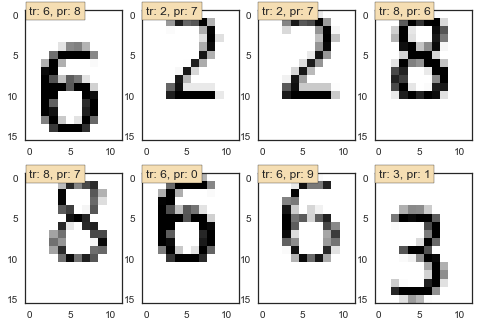

In [71]:
wrong = (Y_test_gen != pred)
if np.any(wrong):
    random_plot(X_test_gen[wrong], Y_test_gen[wrong], pred[wrong])

MLP turns out to be very powerful with 99% accuracy for
augmented data.  
Now let's search through various parameter combinations by grid search to improve the model further more.

In [72]:
pipe = Pipeline([
    ('flatten data to "obs*feature" shape', MyTrans()), 
    ('MLP', MLPClassifier(max_iter=1000))
])
alpha_options = [1e-4, 1e-3, 0.01]
layer_options = [(100,), (100,100), (100,100,100)]
param_grid = dict(
    MLP__alpha=alpha_options,
    MLP__hidden_layer_sizes=layer_options
)

grid_savename = os.path.join(arcdir, 'label_mlp-grid_all.pkl')
if False:  # change to True to do grid search again
    grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=2, verbose=5)
    grid.fit(X_train_gen, Y_train_gen)
    
    joblib.dump(grid, grid_savename)
else:
    grid = joblib.load(grid_savename)

0.9993 (+/-0.0017) for {'MLP__alpha': 0.0001, 'MLP__hidden_layer_sizes': (100, 100, 100)}
0.9992 (+/-0.0016) for {'MLP__alpha': 0.0001, 'MLP__hidden_layer_sizes': (100, 100)}
0.9991 (+/-0.0019) for {'MLP__alpha': 0.01, 'MLP__hidden_layer_sizes': (100, 100, 100)}
0.9991 (+/-0.0019) for {'MLP__alpha': 0.01, 'MLP__hidden_layer_sizes': (100, 100)}
0.9991 (+/-0.0019) for {'MLP__alpha': 0.001, 'MLP__hidden_layer_sizes': (100, 100, 100)}
0.9991 (+/-0.0015) for {'MLP__alpha': 0.001, 'MLP__hidden_layer_sizes': (100,)}
0.9990 (+/-0.0023) for {'MLP__alpha': 0.001, 'MLP__hidden_layer_sizes': (100, 100)}
0.9989 (+/-0.0021) for {'MLP__alpha': 0.01, 'MLP__hidden_layer_sizes': (100,)}
0.9989 (+/-0.0026) for {'MLP__alpha': 0.0001, 'MLP__hidden_layer_sizes': (100,)}
{'MLP__alpha': 0.0001, 'MLP__hidden_layer_sizes': (100, 100, 100)}


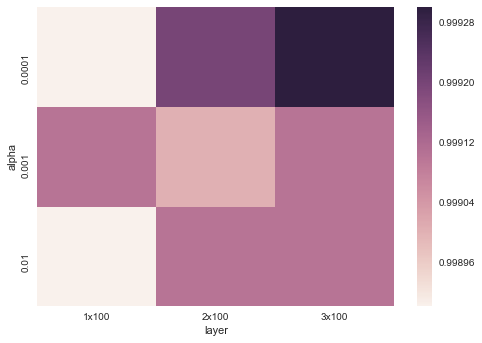

layer,1x100,2x100,3x100
alpha,,,
0.0001,0.998901,0.999201,0.999301
0.0010,0.999101,0.999001,0.999101
0.0100,0.998901,0.999101,0.999101


In [73]:
odr = np.argsort(grid.cv_results_['mean_test_score'])
for i in reversed(odr):
    print("%0.4f (+/-%0.04f) for %r" % 
        (grid.cv_results_['mean_test_score'][i], 
         grid.cv_results_['std_test_score'][i] * 2, 
         grid.cv_results_['params'][i]))
print(grid.best_params_)

avg = grid.cv_results_['mean_test_score']
alpha = [p['MLP__alpha'] for p in grid.cv_results_['params']]
layer = [p['MLP__hidden_layer_sizes'] for p in grid.cv_results_['params']]
layer = ['%dx%3d' % (len(l), l[0]) for l in layer]
df = pd.DataFrame(dict(accuracy=avg, alpha=alpha, layer=layer))
df_wide = df.pivot('alpha', 'layer', 'accuracy')
sns.heatmap(df_wide)
plt.show()
df_wide

In [74]:
savename = os.path.join(modeldir, 'label_mlp-grid.pkl')
joblib.dump(grid.best_estimator_.named_steps['MLP'],  savename)

['/home/kota/Documents/kgschart/models/label_mlp-grid.pkl']

In [75]:
pred = grid.predict(X_test_gen)
print(classification_report(Y_test_gen, pred))
pd.crosstab(pd.Series(Y_test_gen), pd.Series(pred), margins=True)

             precision    recall  f1-score   support

          0       1.00      1.00      1.00       319
          1       1.00      1.00      1.00      1994
          2       1.00      1.00      1.00       599
          3       1.00      1.00      1.00       398
          4       1.00      1.00      1.00       400
          5       1.00      1.00      1.00       440
          6       1.00      1.00      1.00       400
          7       1.00      0.99      1.00       400
          8       1.00      1.00      1.00       439
          9       1.00      1.00      1.00       479
          d       1.00      1.00      1.00       519
          k       1.00      1.00      1.00      3626

avg / total       1.00      1.00      1.00     10013



col_0,0,1,2,3,4,5,6,7,8,9,d,k,All
row_0,,,,,,,,,,,,,
0,319,0,0,0,0,0,0,0,0,0,0,0,319
1,0,1994,0,0,0,0,0,0,0,0,0,0,1994
2,0,0,599,0,0,0,0,0,0,0,0,0,599
3,0,0,0,398,0,0,0,0,0,0,0,0,398
4,0,0,0,0,400,0,0,0,0,0,0,0,400
5,0,0,0,0,0,440,0,0,0,0,0,0,440
6,0,0,0,0,0,0,400,0,0,0,0,0,400
7,0,0,2,0,0,0,0,398,0,0,0,0,400
8,0,0,0,0,0,0,0,0,439,0,0,0,439


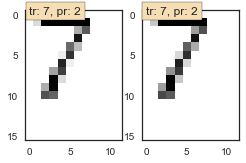

In [76]:
wrong = (Y_test_gen != pred)
if np.any(wrong):
    random_plot(X_test_gen[wrong], Y_test_gen[wrong], pred[wrong])

In [77]:
print(grid.score(X_test_gen, Y_test_gen))
print(grid.score(X_test, Y_test))

0.999800259662
1.0


The best model predicts 99.99% accurate for generated test data (100% for original test data).
But I prefer the second best for no reason (maybe I like three).

In [78]:
pipe = Pipeline([
    ('flatten data to "obs*feature" shape', MyTrans()), 
    ('MLP', MLPClassifier((100,100,100), alpha=0.001, max_iter=1000))
])
fit_mlp = pipe.fit(X_train_gen, Y_train_gen)

0.999600519325
1.0


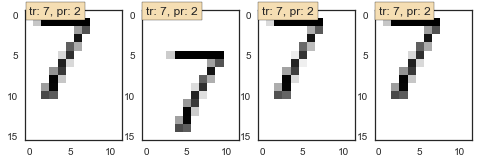

             precision    recall  f1-score   support

          0       1.00      1.00      1.00       319
          1       1.00      1.00      1.00      1994
          2       0.99      1.00      1.00       599
          3       1.00      1.00      1.00       398
          4       1.00      1.00      1.00       400
          5       1.00      1.00      1.00       440
          6       1.00      1.00      1.00       400
          7       1.00      0.99      0.99       400
          8       1.00      1.00      1.00       439
          9       1.00      1.00      1.00       479
          d       1.00      1.00      1.00       519
          k       1.00      1.00      1.00      3626

avg / total       1.00      1.00      1.00     10013



col_0,0,1,2,3,4,5,6,7,8,9,d,k,All
row_0,,,,,,,,,,,,,
0,319,0,0,0,0,0,0,0,0,0,0,0,319
1,0,1994,0,0,0,0,0,0,0,0,0,0,1994
2,0,0,599,0,0,0,0,0,0,0,0,0,599
3,0,0,0,398,0,0,0,0,0,0,0,0,398
4,0,0,0,0,400,0,0,0,0,0,0,0,400
5,0,0,0,0,0,440,0,0,0,0,0,0,440
6,0,0,0,0,0,0,400,0,0,0,0,0,400
7,0,0,4,0,0,0,0,396,0,0,0,0,400
8,0,0,0,0,0,0,0,0,439,0,0,0,439


In [79]:
print(fit_mlp.score(X_test_gen, Y_test_gen))
print(fit_mlp.score(X_test, Y_test))
pred = fit_mlp.predict(X_test_gen)
wrong = (Y_test_gen != pred)
if np.any(wrong):
    random_plot(X_test_gen[wrong], Y_test_gen[wrong], pred[wrong])
print(classification_report(Y_test_gen, pred))
pd.crosstab(pd.Series(Y_test_gen), pd.Series(pred), margins=True)

In [80]:
model_savename = os.path.join(modeldir, 'label_mlp.pkl')
joblib.dump(fit_mlp.named_steps['MLP'], model_savename)

['/home/kota/Documents/kgschart/models/label_mlp.pkl']

**Play more variation of MLP modelling**

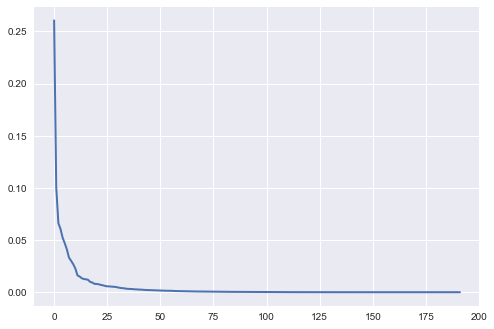

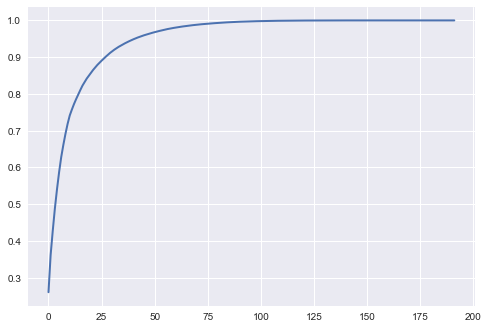

1 0.260575259122
2 0.361202829165
3 0.427398062579
4 0.488119178671
5 0.540429914967
6 0.587396018037
7 0.628500685847
8 0.661667462
9 0.691769106762
10 0.718613048353
11 0.741253316737
12 0.757374972683
13 0.772420445149
14 0.785846065697
15 0.798449276853
16 0.810836112947
17 0.822695830054
18 0.832484402761
19 0.841760738436
20 0.84976756789
21 0.857656454706
22 0.865278249429
23 0.872249234068
24 0.878859576879
25 0.884873189922
26 0.890506160634
27 0.896085597781
28 0.901465041167
29 0.906656012316
30 0.911685700077
31 0.916236956464
32 0.920409833241
33 0.924305125932
34 0.928048740572
35 0.93137417481
36 0.934602809974
37 0.937789033567
38 0.940771054907
39 0.943516921766
40 0.946219451956
41 0.94873945072
42 0.95119141247
43 0.953448314601
44 0.955596988095
45 0.957660687364
46 0.959614091112
47 0.961407119894
48 0.963184147536
49 0.964907365562
50 0.966539747705
51 0.968102329252
52 0.969608556408
53 0.971070707333
54 0.972468716852
55 0.973855819314
56 0.975217436371
57 0.976

In [81]:
pipe_pca = Pipeline([
    ('flatten data to "obs*feature" shape', MyTrans()), 
    ('PCA', PCA())
])

pca = pipe_pca.fit(X_train_gen)
sns.set()
plt.plot(pca.named_steps['PCA'].explained_variance_ratio_, linewidth=2)
plt.show(block=False)

cum = pca.named_steps['PCA'].explained_variance_ratio_.cumsum()
plt.plot(cum, linewidth=2)
plt.show(block=False)
for i in range(len(cum)):
    print(i+1, cum[i])


In [82]:
pipe = Pipeline([
    ('flatten data to "obs*feature" shape', MyTrans()), 
    ('PCA', PCA(n_components=50)),
    ('MLP', MLPClassifier((50,50,50), alpha=1e-6, max_iter=1000))
])

In [83]:
fit_pca_mlp = pipe.fit(X_train_gen, Y_train_gen)

0.999700389494
1.0


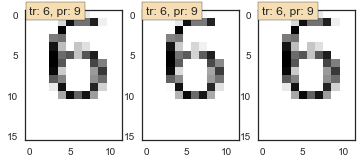

             precision    recall  f1-score   support

          0       1.00      1.00      1.00       319
          1       1.00      1.00      1.00      1994
          2       1.00      1.00      1.00       599
          3       1.00      1.00      1.00       398
          4       1.00      1.00      1.00       400
          5       1.00      1.00      1.00       440
          6       1.00      0.99      1.00       400
          7       1.00      1.00      1.00       400
          8       1.00      1.00      1.00       439
          9       1.00      1.00      1.00       479
          d       1.00      1.00      1.00       519
          k       1.00      1.00      1.00      3626

avg / total       1.00      1.00      1.00     10013



col_0,0,1,2,3,4,5,6,7,8,9,d,k,All
row_0,,,,,,,,,,,,,
0,319,0,0,0,0,0,0,0,0,0,0,0,319
1,0,1994,0,0,0,0,0,0,0,0,0,0,1994
2,0,0,599,0,0,0,0,0,0,0,0,0,599
3,0,0,0,398,0,0,0,0,0,0,0,0,398
4,0,0,0,0,400,0,0,0,0,0,0,0,400
5,0,0,0,0,0,440,0,0,0,0,0,0,440
6,0,0,0,0,0,0,398,0,0,2,0,0,400
7,0,0,0,0,0,0,0,400,0,0,0,0,400
8,0,0,0,0,0,1,0,0,438,0,0,0,439


In [84]:
print(fit_pca_mlp.score(X_test_gen, Y_test_gen))
print(fit_pca_mlp.score(X_test, Y_test))
pred = fit_pca_mlp.predict(X_test_gen)
wrong = (Y_test_gen != pred)
if np.any(wrong):
    random_plot(X_test_gen[wrong], Y_test_gen[wrong], pred[wrong])
print(classification_report(Y_test_gen, pred))
pd.crosstab(pd.Series(Y_test_gen), pd.Series(pred), margins=True)

In [85]:
savename = os.path.join(modeldir, 'label_pca-mlp.pkl')
joblib.dump(Pipeline(fit_pca_mlp.steps[1:]), savename)

['/home/kota/Documents/kgschart/models/label_pca-mlp.pkl']

**Train until predict test data perfect**

In [86]:
np.random.seed(87)

classes = fit_mlp.classes_
model = MLPClassifier((100,100,100), alpha=0.0001, warm_start=True)
trans = MyTrans()
pipe = Pipeline([
    ('flatten data to "obs*feature" shape', trans), 
    ('MLP', model)
])


train_gen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, 
                               data_format='channels_last', channel_shift_range=0.5)

num = 0
result = None
counter = 0
consec_ones = 0
for X_batch,Y_batch in train_gen.flow(np.expand_dims(X_train, axis=4), 
                                      Y_train, batch_size=100):
    counter += 1
    if counter > 5000: break
        
    model.partial_fit(trans.transform(X_batch.squeeze()), 
                      Y_batch, classes)
    num += len(Y_batch)
    
    test_score     = pipe.score(X_test, Y_test)
    test_gen_score = pipe.score(X_test_gen, Y_test_gen)
    tmp = dict(size = [num], test_score = [test_score], 
               test_gen_score = [test_gen_score])
    tmp = pd.DataFrame(tmp)
    if result is None:
        result = tmp
    else:
        result = result.append(tmp)
    
    if counter % 100 == 1:
        print(num, 'test_gen_score =', test_gen_score,
              'test_score =', test_score)
    if test_score == 1.0 and test_gen_score == 1.0:
        consec_ones += 1
    if consec_ones >= 10:
        print('DONE!')
        break

100 test_gen_score = 0.2031359233 test_score = 0.362549800797
8483 test_gen_score = 0.880755018476 test_score = 0.96015936255
16817 test_gen_score = 0.981823629282 test_score = 1.0
25200 test_gen_score = 0.987016878059 test_score = 1.0
33583 test_gen_score = 0.991710775991 test_score = 1.0
41917 test_gen_score = 0.995805452911 test_score = 1.0
50300 test_gen_score = 0.998002596624 test_score = 1.0
58683 test_gen_score = 0.997902726456 test_score = 1.0
67017 test_gen_score = 0.99920103865 test_score = 1.0
75400 test_gen_score = 0.999600519325 test_score = 1.0
DONE!


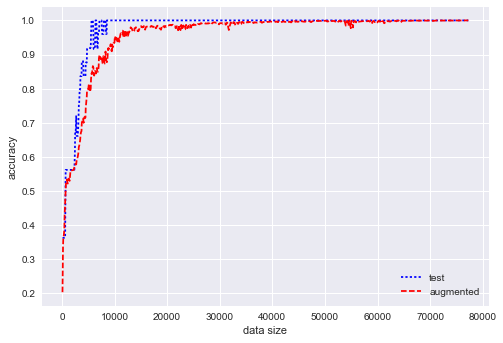

In [87]:
sns.set()
plt.plot(result['size'], result['test_score'], 'b:', label='test')
plt.plot(result['size'], result['test_gen_score'], 'r--', label='augmented') 
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('data size')
plt.show(block=False)

In [88]:
fit = pipe
savename = os.path.join(modeldir, 'label_mlp-full.pkl')
joblib.dump(fit.named_steps['MLP'], savename)

['/home/kota/Documents/kgschart/models/label_mlp-full.pkl']

In [89]:
print(fit.score(X_test_gen, Y_test_gen))
print(fit.score(X_test, Y_test))
pred = fit.predict(X_test_gen)
wrong = (Y_test_gen != pred)
if np.any(wrong):
    random_plot(X_test_gen[wrong], Y_test_gen[wrong], pred[wrong])
print(classification_report(Y_test_gen, pred))
pd.crosstab(pd.Series(Y_test_gen), pd.Series(pred), margins=True)

1.0
1.0
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       319
          1       1.00      1.00      1.00      1994
          2       1.00      1.00      1.00       599
          3       1.00      1.00      1.00       398
          4       1.00      1.00      1.00       400
          5       1.00      1.00      1.00       440
          6       1.00      1.00      1.00       400
          7       1.00      1.00      1.00       400
          8       1.00      1.00      1.00       439
          9       1.00      1.00      1.00       479
          d       1.00      1.00      1.00       519
          k       1.00      1.00      1.00      3626

avg / total       1.00      1.00      1.00     10013



col_0,0,1,2,3,4,5,6,7,8,9,d,k,All
row_0,,,,,,,,,,,,,
0,319,0,0,0,0,0,0,0,0,0,0,0,319
1,0,1994,0,0,0,0,0,0,0,0,0,0,1994
2,0,0,599,0,0,0,0,0,0,0,0,0,599
3,0,0,0,398,0,0,0,0,0,0,0,0,398
4,0,0,0,0,400,0,0,0,0,0,0,0,400
5,0,0,0,0,0,440,0,0,0,0,0,0,440
6,0,0,0,0,0,0,400,0,0,0,0,0,400
7,0,0,0,0,0,0,0,400,0,0,0,0,400
8,0,0,0,0,0,0,0,0,439,0,0,0,439


This final model predicts 100% accuracy for the augmented data.  
Question: Which model should I use?  
All MLP models should be good enough for this case, though.

**Train PCA-MLP model exhaustively**

In [90]:
np.random.seed(87)

classes = fit_mlp.classes_
model = MLPClassifier((100,100,100), alpha=0.0001, warm_start=True)

# create data prep pipeline and
# fit pca before learning
# this way, we can fix the features to pass to MLP
# if we use incrementalPCA and fit online, then the MLP learning would 
# mess up since there is no guarantee that PCA component i now is the 
# same as the component i in the next fitted PCA
pca = PCA(n_components=100)
pipe_prep = Pipeline([
    ('flatten', MyTrans()), 
    ('PCA', pca)
])
pipe_prep.fit(X_train_gen)

pipe_pred = Pipeline([
    ('prep', pipe_prep),
    ('MLP', model)
])

In [91]:
train_gen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, 
                               data_format='channels_last', channel_shift_range=0.5)

num = 0
result = None
counter = 0
consec_ones = 0
for X_batch,Y_batch in train_gen.flow(np.expand_dims(X_train, axis=4), 
                                      Y_train, batch_size=100):
    counter += 1
    if counter > 5000: break
        
    model.partial_fit(pipe_prep.transform(X_batch.squeeze()), 
                      Y_batch, classes)
    num += len(Y_batch)
    
    test_score     = pipe_pred.score(X_test, Y_test)
    test_gen_score = pipe_pred.score(X_test_gen, Y_test_gen)
    tmp = dict(size = [num], test_score = [test_score], 
               test_gen_score = [test_gen_score])
    tmp = pd.DataFrame(tmp)
    if result is None:
        result = tmp
    else:
        result = result.append(tmp)
    
    if counter % 100 == 1:
        print(num, 'test_gen_score =', test_gen_score,
              'test_score =', test_score)
    if test_score == 1.0 and test_gen_score == 1.0:
        consec_ones += 1
    if consec_ones >= 10:
        print('DONE!')
        break

100 test_gen_score = 0.0402476780186 test_score = 0.0398406374502
8483 test_gen_score = 0.966343753121 test_score = 1.0
16817 test_gen_score = 0.99430740038 test_score = 1.0
25200 test_gen_score = 0.999300908819 test_score = 1.0
DONE!


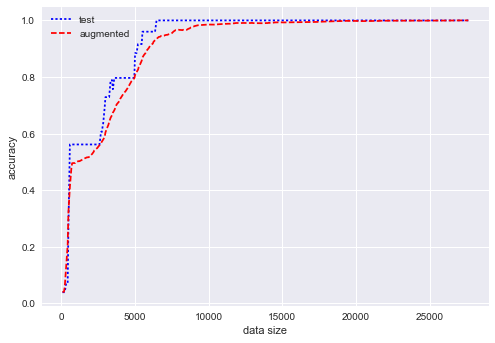

In [92]:
plt.plot(result['size'], result['test_score'], 'b:', label='test')
plt.plot(result['size'], result['test_gen_score'], 'r--', label='augmented') 
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('data size')
plt.show(block=False)

This looks good!

In [93]:
print(fit.score(X_test_gen, Y_test_gen))
print(fit.score(X_test, Y_test))
pred = fit.predict(X_test_gen)
wrong = (Y_test_gen != pred)
if np.any(wrong):
    random_plot(X_test_gen[wrong], Y_test_gen[wrong], pred[wrong])
print(classification_report(Y_test_gen, pred))
pd.crosstab(pd.Series(Y_test_gen), pd.Series(pred), margins=True)

1.0
1.0
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       319
          1       1.00      1.00      1.00      1994
          2       1.00      1.00      1.00       599
          3       1.00      1.00      1.00       398
          4       1.00      1.00      1.00       400
          5       1.00      1.00      1.00       440
          6       1.00      1.00      1.00       400
          7       1.00      1.00      1.00       400
          8       1.00      1.00      1.00       439
          9       1.00      1.00      1.00       479
          d       1.00      1.00      1.00       519
          k       1.00      1.00      1.00      3626

avg / total       1.00      1.00      1.00     10013



col_0,0,1,2,3,4,5,6,7,8,9,d,k,All
row_0,,,,,,,,,,,,,
0,319,0,0,0,0,0,0,0,0,0,0,0,319
1,0,1994,0,0,0,0,0,0,0,0,0,0,1994
2,0,0,599,0,0,0,0,0,0,0,0,0,599
3,0,0,0,398,0,0,0,0,0,0,0,0,398
4,0,0,0,0,400,0,0,0,0,0,0,0,400
5,0,0,0,0,0,440,0,0,0,0,0,0,440
6,0,0,0,0,0,0,400,0,0,0,0,0,400
7,0,0,0,0,0,0,0,400,0,0,0,0,400
8,0,0,0,0,0,0,0,0,439,0,0,0,439


In [94]:
# when saving, we combine PCA and MLP part
pipe = Pipeline([
    ('PCA', pca), ('MLP', model)
])
savename = os.path.join(modeldir, 'label_pca-mlp-full.pkl')
joblib.dump(pipe, savename)

['/home/kota/Documents/kgschart/models/label_pca-mlp-full.pkl']